# Challenge: Validating a linear regression

[Download the Excel file here](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls) on crime data in New York State in 2013, provided by the FBI: UCR.

Prepare this data to model with multivariable regression (including data cleaning if necessary) according to this specification:

Propertycrime=α+Population+Population^2+Murder+Robbery
 
The 'population' variable is already set for you, but you will need to create the last three features. Robbery and Murder are currently continuous variables. For this model, please use these variables to create categorical features where values greater than 0 are coded 1, and values equal to 0 are coded 0. You'll use this data and model in a later assignment- for now, just write the code you need to get the data ready. Don't forget basic data cleaning procedures, either! Do some graphing to see if there are any anomalous cases, and decide how you want to deal with them.

1) The figures shown in this column for the offense of rape were reported using the revised Uniform Crime Reporting (UCR) definition of rape. See Data Declaration for further explanation.

2) The figures shown in this column for the offense of rape were reported using the legacy UCR definition of rape. See Data Declaration for further explanation.

3) The FBI does not publish arson data unless it receives data from either the agency or the state for all 12 months of the calendar year.

**Link to the [Data Declaration](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls/@@template-layout-view?override-view=data-declaration) page**

----------------------------------------------------------------------------------------------------------------------

**Challenge:** The procedure is the same as what you learned in the Naive Bayes lesson – the holdout method and cross-validation method are both available. You've already had experience writing code to run these kinds of validation models for Naive Bayes: now you can try it again with linear regression. In this case, your goal is to achieve a model with a consistent R2 and only statistically significant parameters across multiple samples.

We'll use the property crime model you've been working on with, based on the FBI:UCR data. Since your model formulation to date has used the entire New York State 2013 dataset, you'll need to validate it using some of the other crime datasets available at the FBI:UCR website. Options include other states crime rates in 2013 or crime rates in New York State in other years or a combination of these.

Iterate
Based on the results of your validation test, create a revised model, and then test both old and new models on a new holdout or set of folds.

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import sklearn
from sklearn import linear_model
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
%matplotlib inline
sns.set_style('white')
# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

## Linear regression for New York state

In [2]:
# import data and show format
df_ny = pd.read_csv('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.csv')
# rename the columns
df_ny.rename(columns={'Table 8': 'City', 'Unnamed: 1': 'Population', 'Unnamed: 2': 'Violent_crime', 
                   'Unnamed: 3': 'Murder', 'Unnamed: 4': 'Rape (revised definition)', 
                   'Unnamed: 5': 'Rape', 'Unnamed: 6': 'Robbery', 
                   'Unnamed: 7': 'Aggravated_assault', 'Unnamed: 8': 'Property_crime', 
                   'Unnamed: 9': 'Burglary', 'Unnamed: 10': 'Larceny_theft', 'Unnamed: 11': 'Motor_vehicle_theft',
                   'Unnamed: 12': 'Arson'}, inplace=True)
# drop title rows from the csv file
df_ny=df_ny.drop(['Unnamed: 13', 'Rape (revised definition)'], axis=1)
df_ny=df_ny.drop([0, 1, 2, 3, 352, 353, 354], axis=0)
df_ny.head()

,City,Population,Violent_crime,Murder,Rape,Robbery,Aggravated_assault,Property_crime,Burglary,Larceny_theft,Motor_vehicle_theft,Arson
4,Adams Village,"1,861",0,0,0,0,0,12,2,10,0,0
5,Addison Town and Village,"2,577",3,0,0,0,3,24,3,20,1,0
6,Akron Village,"2,846",3,0,0,0,3,16,1,15,0,0
7,Albany,"97,956",791,8,30,227,526,"4,090",705,"3,243",142,NaN
8,Albion Village,"6,388",23,0,3,4,16,223,53,165,5,NaN


In [3]:
# add state column
df_ny['State']='NY'
# convert all numerical columns to integers
for x in df_ny.index:
    df_ny['Population'].loc[x]=int(df_ny['Population'].loc[x].replace(',', ''))
    df_ny['Violent_crime'].loc[x]=int(df_ny['Violent_crime'].loc[x].replace(',', ''))
    df_ny['Murder'].loc[x]=int(df_ny['Murder'].loc[x].replace(',', ''))
    df_ny['Rape'].loc[x]=int(df_ny['Rape'].loc[x].replace(',', ''))
    df_ny['Robbery'].loc[x]=int(df_ny['Robbery'].loc[x].replace(',', ''))
    df_ny['Aggravated_assault'].loc[x]=int(df_ny['Aggravated_assault'].loc[x].replace(',', ''))
    df_ny['Property_crime'].loc[x]=int(df_ny['Property_crime'].loc[x].replace(',', ''))
    df_ny['Burglary'].loc[x]=int(df_ny['Burglary'].loc[x].replace(',', ''))
    df_ny['Larceny_theft'].loc[x]=int(df_ny['Larceny_theft'].loc[x].replace(',', ''))
    df_ny['Motor_vehicle_theft'].loc[x]=int(df_ny['Motor_vehicle_theft'].loc[x].replace(',', ''))
# values for Arson contain string, integers, and floats. Convert all to floats
df_ny['Arson']=df_ny['Arson'].astype(float)

/Users/kyleknoebel/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### Graphing to find anamolies

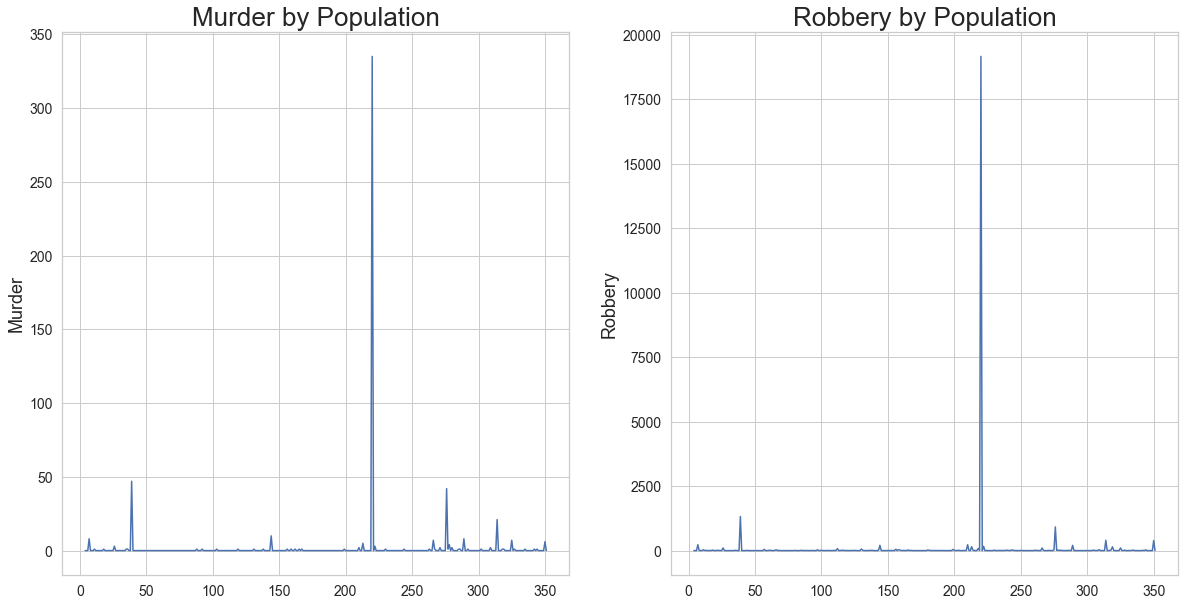

In [4]:
sns.set(style='whitegrid')
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.lineplot(x=df_ny.index, y='Murder', data=df_ny)
plt.ylabel('Murder', fontsize=18)
plt.tick_params(axis='both', which='both', labelsize=14)
plt.title('Murder by Population', fontsize=26)


plt.subplot(1, 2, 2)
sns.lineplot(x=df_ny.index, y='Robbery', data=df_ny)
plt.ylabel('Robbery', fontsize=18)
plt.tick_params(axis='both', which='both', labelsize=14)
plt.title('Robbery by Population', fontsize=26)
plt.show()

There does seem to be an anamoly for both murder and robbery. The anamoly comes from the City of New York, the [most populous city in the United States.](https://en.wikipedia.org/wiki/New_York_City) As such, it is beneificial for the analysis to remove New York City from the dataset. 

Below the population squared and binary categories for murder and robbery are added. 

In [5]:
# add a population^2 column and add inputs
df_ny['Population^2']=df_ny['Population']**2

# add murder cat column and add inputs
df_ny['Murder Cat']=''
for x in df_ny.index:
    if df_ny['Murder'].loc[x] == 0:
          df_ny['Murder Cat'].loc[x]=df_ny['Murder Cat'].loc[x].replace('', '0')
    else:
          df_ny['Murder Cat'].loc[x]=df_ny['Murder Cat'].loc[x].replace('', '1')
# add robbery cat column and add inputs
df_ny['Robbery Cat']=''
for x in df_ny.index:
    if df_ny['Robbery'].loc[x] == 0:
          df_ny['Robbery Cat'].loc[x]=df_ny['Robbery Cat'].loc[x].replace('', '0')
    else:
          df_ny['Robbery Cat'].loc[x]=df_ny['Robbery Cat'].loc[x].replace('', '1')
# convert Robbery Cat and Murder Cat to integers
for x in df_ny.index:
    df_ny['Murder Cat'].loc[x]=int(df_ny['Murder Cat'].loc[x])
    df_ny['Robbery Cat'].loc[x]=int(df_ny['Robbery Cat'].loc[x])         
df_ny.head()

/Users/kyleknoebel/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,City,Population,Violent_crime,Murder,Rape,Robbery,Aggravated_assault,Property_crime,Burglary,Larceny_theft,Motor_vehicle_theft,Arson,State,Population^2,Murder Cat,Robbery Cat
4,Adams Village,1861,0,0,0,0,0,12,2,10,0,0.000,NY,3463321,0,0
5,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,0.000,NY,6640929,0,0
6,Akron Village,2846,3,0,0,0,3,16,1,15,0,0.000,NY,8099716,0,0
7,Albany,97956,791,8,30,227,526,4090,705,3243,142,nan,NY,9595377936,1,1
8,Albion Village,6388,23,0,3,4,16,223,53,165,5,nan,NY,40806544,0,1


Propertycrime=α+Population+Population^2+Murder+Robbery, which is added to the dataframe as 'Property crime calc.'

In [6]:
# remove NYC from dataframe
df_wony=df_ny.drop(220)

In [7]:
df_ny.head()

,City,Population,Violent_crime,Murder,Rape,Robbery,Aggravated_assault,Property_crime,Burglary,Larceny_theft,Motor_vehicle_theft,Arson,State,Population^2,Murder Cat,Robbery Cat
4,Adams Village,1861,0,0,0,0,0,12,2,10,0,0.000,NY,3463321,0,0
5,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,0.000,NY,6640929,0,0
6,Akron Village,2846,3,0,0,0,3,16,1,15,0,0.000,NY,8099716,0,0
7,Albany,97956,791,8,30,227,526,4090,705,3243,142,nan,NY,9595377936,1,1
8,Albion Village,6388,23,0,3,4,16,223,53,165,5,nan,NY,40806544,0,1


In [8]:
from sklearn import linear_model
import statsmodels.api as sm
# Instantiate and fit our model.
Y = df_ny['Property_crime'].values.reshape(-1, 1)
X = df_ny[['Population', 'Population^2', 'Murder', 'Robbery']]
X = sm.add_constant(X)
# Note the difference in argument order
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 6.806e+04
Date:                Wed, 21 Nov 2018   Prob (F-statistic):               0.00
Time:                        12:16:19   Log-Likelihood:                -2443.7
No. Observations:                 348   AIC:                             4897.
Df Residuals:                     343   BIC:                             4917.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           24.1436     18.638      1.295      0.196     -12.516      60.804
Population       0.0159      0.001     16.639      0.000       0.014       0.018
Population^2  -1.01e-09      1e-10    -10.055      0.000   -1.21e-09   -8.13e-10
Murder         117.5595     15.046      7.813      0.000      87.966     147.153
Robbery          2.0919      0.666      3.142      0.002       0.783       3.401
==============================================================================
Omnibus:                      157.528   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7048.769
Skew:                          -1.111   Prob(JB):                         0.00
Kurtosis:                      24.936   Cond. No.                     4.82e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.82e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
# Instantiate and fit our model.
Y = df_wony['Property_crime'].values.reshape(-1, 1)
X = df_wony[['Population', 'Population^2', 'Murder', 'Robbery']]
X = sm.add_constant(X)
# Note the difference in argument order
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     1323.
Date:                Wed, 21 Nov 2018   Prob (F-statistic):          1.43e-206
Time:                        12:16:19   Log-Likelihood:                -2414.5
No. Observations:                 347   AIC:                             4839.
Df Residuals:                     342   BIC:                             4858.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -25.0399     18.877     -1.326      0.186     -62.169      12.089
Population       0.0206      0.001     18.350      0.000       0.018       0.023
Population^2 -7.195e-08   1.03e-08     -7.010      0.000   -9.21e-08   -5.18e-08
Murder         102.6434     14.278      7.189      0.000      74.559     130.728
Robbery          5.1300      0.764      6.718      0.000       3.628       6.632
==============================================================================
Omnibus:                      173.424   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4534.307
Skew:                          -1.499   Prob(JB):                         0.00
Kurtosis:                      20.453   Cond. No.                     7.07e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.07e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

While the regression test that includes New York City results in a much higher R-squared value, the city's inclusion looks to skew the result. The R-squared value in the second set is likely to be more accurate, so the 'df_wony' dataset without New York City will be chosen for further testing.   

## Predicting property crime for California

In [10]:
# import CA data and show format
df_ca = pd.read_csv('table_8_offenses_known_to_law_enforcement_california_by_city_2013.csv')
# rename the columns
df_ca.rename(columns={'Table 8': 'City', 'Unnamed: 1': 'Population', 'Unnamed: 2': 'Violent_crime', 
                   'Unnamed: 3': 'Murder', 'Unnamed: 4': 'Rape (revised definition)', 
                   'Unnamed: 5': 'Rape', 'Unnamed: 6': 'Robbery', 
                   'Unnamed: 7': 'Aggravated_assault', 'Unnamed: 8': 'Property_crime', 
                   'Unnamed: 9': 'Burglary', 'Unnamed: 10': 'Larceny_theft', 'Unnamed: 11': 'Motor_vehicle_theft',
                   'Unnamed: 12': 'Arson'}, inplace=True)
# drop title rows from the csv file
df_ca=df_ca.drop(['Unnamed: 13', 'Rape (revised definition)'], axis=1)
df_ca=df_ca.drop([0, 1, 2, 3, 466, 467], axis=0)
df_ca.head()

,City,Population,Violent_crime,Murder,Rape,Robbery,Aggravated_assault,Property_crime,Burglary,Larceny_theft,Motor_vehicle_theft,Arson
4,Adelanto,"31,165",198,2,15,52,129,886,381,372,133,17
5,Agoura Hills,"20,762",19,0,2,10,7,306,109,185,12,7
6,Alameda,"76,206",158,0,10,85,63,"1,902",287,"1,285",330,17
7,Albany,"19,104",29,0,1,24,4,557,94,388,75,7
8,Alhambra,"84,710",163,1,9,81,72,"1,774",344,"1,196",234,7


In [11]:
# add state column
df_ca['State']='CA'
# convert all numerical columns to integers
for x in df_ca.index:
    df_ca['Population'].loc[x]=int(df_ca['Population'].loc[x].replace(',', ''))
    df_ca['Violent_crime'].loc[x]=int(df_ca['Violent_crime'].loc[x].replace(',', ''))
    df_ca['Murder'].loc[x]=int(df_ca['Murder'].loc[x].replace(',', ''))
    df_ca['Rape'].loc[x]=int(df_ca['Rape'].loc[x].replace(',', ''))
    df_ca['Robbery'].loc[x]=int(df_ca['Robbery'].loc[x].replace(',', ''))
    df_ca['Aggravated_assault'].loc[x]=int(df_ca['Aggravated_assault'].loc[x].replace(',', ''))
    df_ca['Property_crime'].loc[x]=int(df_ca['Property_crime'].loc[x].replace(',', ''))
    df_ca['Burglary'].loc[x]=int(df_ca['Burglary'].loc[x].replace(',', ''))
    df_ca['Larceny_theft'].loc[x]=int(df_ca['Larceny_theft'].loc[x].replace(',', ''))
    df_ca['Motor_vehicle_theft'].loc[x]=int(df_ca['Motor_vehicle_theft'].loc[x].replace(',', ''))
    df_ca['Arson'].loc[x]=int(df_ca['Arson'].loc[x].replace(',', ''))

/Users/kyleknoebel/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### Graph to find anamolies

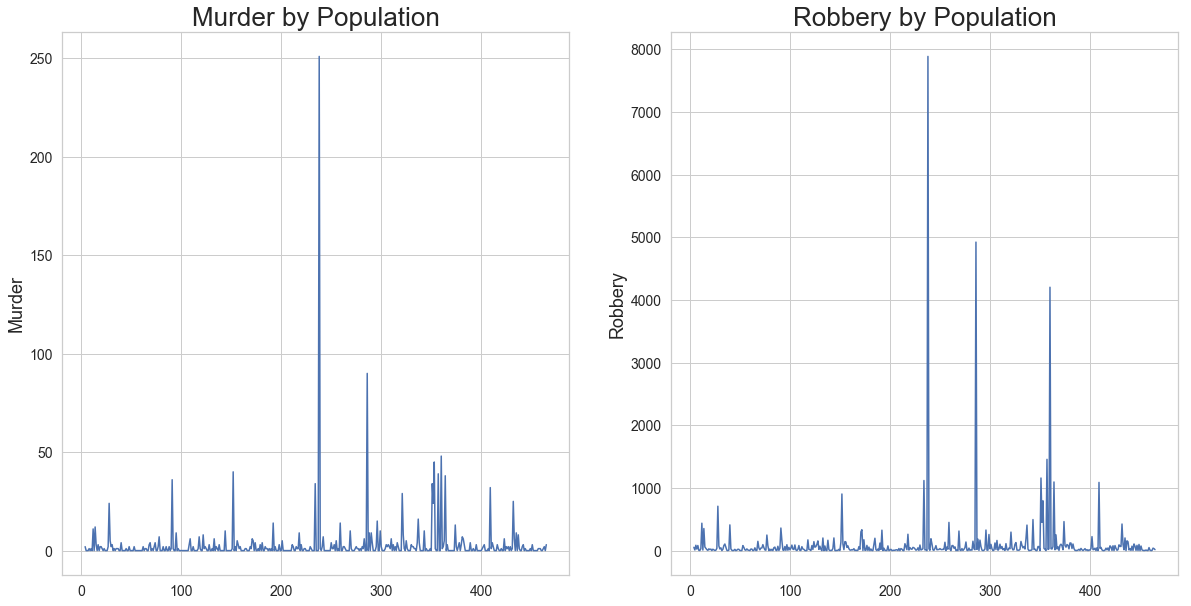

In [12]:
sns.set(style='whitegrid')
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.lineplot(x=df_ca.index, y='Murder', data=df_ca)
plt.ylabel('Murder', fontsize=18)
plt.tick_params(axis='both', which='both', labelsize=14)
plt.title('Murder by Population', fontsize=26)


plt.subplot(1, 2, 2)
sns.lineplot(x=df_ca.index, y='Robbery', data=df_ca)
plt.ylabel('Robbery', fontsize=18)
plt.tick_params(axis='both', which='both', labelsize=14)
plt.title('Robbery by Population', fontsize=26)
plt.show()

In [13]:
df_ca['Murder'].idxmax()

238

In [14]:
df_ca.loc[238]

City                   Los Angeles
Population                 3878725
Violent_crime                16524
Murder                         251
Rape                           764
Robbery                       7885
Aggravated_assault            7624
Property_crime               85844
Burglary                     15728
Larceny_theft                55734
Motor_vehicle_theft          14382
Arson                         1430
State                           CA
Name: 238, dtype: object

California also has an anomoly for both murder and robbery. The anamoly comes from the City of Los Angeles, the [most populous city in California.](http://worldpopulationreview.com/states/california-population/cities/) However, more testing will be done below to decide whether Los Angeles should be removed from the analysis.

Below the population squared and binary categories for murder and robbery are added. 

In [15]:
# add a population^2 column and add inputs
df_ca['Population^2']=df_ca['Population']**2

# add murder cat column and add inputs
df_ca['Murder Cat']=''
for x in df_ca.index:
    if df_ca['Murder'].loc[x] == 0:
          df_ca['Murder Cat'].loc[x]=df_ca['Murder Cat'].loc[x].replace('', '0')
    else:
          df_ca['Murder Cat'].loc[x]=df_ca['Murder Cat'].loc[x].replace('', '1')
# add robbery cat column and add inputs
df_ca['Robbery Cat']=''
for x in df_ca.index:
    if df_ca['Robbery'].loc[x] == 0:
          df_ca['Robbery Cat'].loc[x]=df_ca['Robbery Cat'].loc[x].replace('', '0')
    else:
          df_ca['Robbery Cat'].loc[x]=df_ca['Robbery Cat'].loc[x].replace('', '1')
# convert Robbery Cat and Murder Cat to integers
for x in df_ca.index:
    df_ca['Murder Cat'].loc[x]=int(df_ca['Murder Cat'].loc[x])
    df_ca['Robbery Cat'].loc[x]=int(df_ca['Robbery Cat'].loc[x])         
df_ca.head()

/Users/kyleknoebel/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,City,Population,Violent_crime,Murder,Rape,Robbery,Aggravated_assault,Property_crime,Burglary,Larceny_theft,Motor_vehicle_theft,Arson,State,Population^2,Murder Cat,Robbery Cat
4,Adelanto,31165,198,2,15,52,129,886,381,372,133,17,CA,971257225,1,1
5,Agoura Hills,20762,19,0,2,10,7,306,109,185,12,7,CA,431060644,0,1
6,Alameda,76206,158,0,10,85,63,1902,287,1285,330,17,CA,5807354436,0,1
7,Albany,19104,29,0,1,24,4,557,94,388,75,7,CA,364962816,0,1
8,Alhambra,84710,163,1,9,81,72,1774,344,1196,234,7,CA,7175784100,1,1


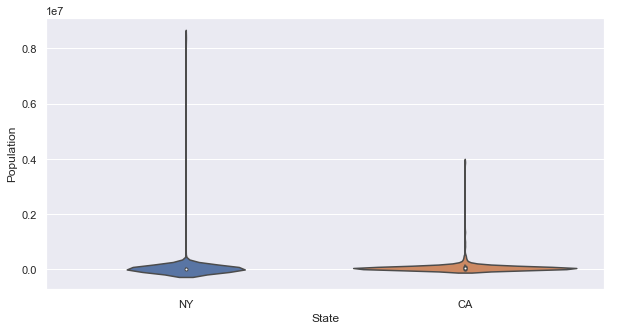

In [16]:
# create a test dataframe that join the data for CA and NY
df_vartest=df_ny.append(df_ca)
sns.set()
plt.figure(figsize=(10, 5))
sns.violinplot('State', 'Population', data=df_vartest)

New York has a much higher variance in city population when compared to California. Due to this difference in population variance, it is recommended to keep Los Angeles in the data for prediction, but the model will be run on California data with and without Los Angelese to ensure accuracy. 

In [17]:
# remove LA from dataframe
df_woca=df_ca.drop(238)

In [18]:
# run the model on new set of data
X = df_ca[['Population', 'Population^2', 'Murder', 'Robbery']]
X = sm.add_constant(X)
# Note the difference in argument order
model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     1323.
Date:                Wed, 21 Nov 2018   Prob (F-statistic):          1.43e-206
Time:                        12:17:15   Log-Likelihood:                -2414.5
No. Observations:                 347   AIC:                             4839.
Df Residuals:                     342   BIC:                             4858.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -25.0399     18.877     -1.326      0.186     -62.169      12.089
Population       0.0206      0.001     18.350      0.000       0.018       0.023
Population^2 -7.195e-08   1.03e-08     -7.010      0.000   -9.21e-08   -5.18e-08
Murder         102.6434     14.278      7.189      0.000      74.559     130.728
Robbery          5.1300      0.764      6.718      0.000       3.628       6.632
==============================================================================
Omnibus:                      173.424   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4534.307
Skew:                          -1.499   Prob(JB):                         0.00
Kurtosis:                      20.453   Cond. No.                     7.07e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.07e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model works well with California data as well, with a high R-squared value. The only issue is the multicollinearity, which will be investigated below. How does the model work without Los Angeles' data?

In [19]:
# run the model on new set of data
X = df_woca[['Population', 'Population^2', 'Murder', 'Robbery']]
X = sm.add_constant(X)
# Note the difference in argument order
model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     1323.
Date:                Wed, 21 Nov 2018   Prob (F-statistic):          1.43e-206
Time:                        12:17:15   Log-Likelihood:                -2414.5
No. Observations:                 347   AIC:                             4839.
Df Residuals:                     342   BIC:                             4858.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -25.0399     18.877     -1.326      0.186     -62.169      12.089
Population       0.0206      0.001     18.350      0.000       0.018       0.023
Population^2 -7.195e-08   1.03e-08     -7.010      0.000   -9.21e-08   -5.18e-08
Murder         102.6434     14.278      7.189      0.000      74.559     130.728
Robbery          5.1300      0.764      6.718      0.000       3.628       6.632
==============================================================================
Omnibus:                      173.424   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4534.307
Skew:                          -1.499   Prob(JB):                         0.00
Kurtosis:                      20.453   Cond. No.                     7.07e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.07e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R-squared value does not changes at all with and without Los Angeles in the data, showing that the city does not skew the data.

## Test statistics

In [20]:
# create a test dataframe that join the data for CA and NY
df_test=df_wony.append(df_ca)
df_test.head()

,City,Population,Violent_crime,Murder,Rape,Robbery,Aggravated_assault,Property_crime,Burglary,Larceny_theft,Motor_vehicle_theft,Arson,State,Population^2,Murder Cat,Robbery Cat
4,Adams Village,1861,0,0,0,0,0,12,2,10,0,0.000,NY,3463321,0,0
5,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,0.000,NY,6640929,0,0
6,Akron Village,2846,3,0,0,0,3,16,1,15,0,0.000,NY,8099716,0,0
7,Albany,97956,791,8,30,227,526,4090,705,3243,142,nan,NY,9595377936,1,1
8,Albion Village,6388,23,0,3,4,16,223,53,165,5,nan,NY,40806544,0,1


In [21]:
linear_formula = 'Property_crime ~ Population+Violent_crime+Murder+Rape+Robbery+Aggravated_assault+Burglary+Larceny_theft+Motor_vehicle_theft'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=df_test).fit()

In [22]:
lm.pvalues

Intercept             0.641
Population            0.000
Violent_crime         0.788
Murder                0.685
Rape                  0.886
Robbery               0.638
Aggravated_assault    0.703
Burglary              0.000
Larceny_theft         0.000
Motor_vehicle_theft   0.000
dtype: float64